In [1]:
import os
import pickle
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import optax
from sgmcmcjax.optimizer import build_optax_optimizer
from sgmcmcjax.samplers import build_sgld_sampler
from sgmcmcjax.samplers import build_sgldCV_sampler, build_sgld_SVRG_sampler, build_psgld_sampler
from sgmcmcjax.samplers import build_sghmc_sampler, build_sghmcCV_sampler, build_sghmc_SVRG_sampler
from sgmcmcjax.samplers import build_baoab_sampler, build_sgnht_sampler, build_badodab_sampler
from sgmcmcjax.samplers import build_sgnhtCV_sampler, build_badodabCV_sampler
from sgmcmcjax.kernels import build_sgld_SVRG_kernel, build_sghmc_SVRG_kernel, build_sgldAdam_kernel, build_sgld_kernel, build_sghmc_kernel, build_baoab_kernel, build_sgnht_kernel, build_badodab_kernel, build_psgld_kernel, build_sgldCV_kernel
import numpy as np
from scipy.stats import t
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
import numpyro
from numpyro.distributions import *
from numpyro.infer.util import initialize_model
from functools import partial
from tqdm.auto import tqdm
import multiprocessing
from progress_bar import scan_tqdm

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"

In [2]:
observations = pickle.load(open('test/luad34.regions.entropies.observations.pkl', 'rb')) 

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [34]:
def mu(n, s, phi, c, cs):
    return jnp.log2((2 * n + (1 - n) * (s * cs + (1 - s) * c)) / \
                        (2 * n + (1 - n) * phi))
n = 0.97
s = 0.1
phi = 2.7
mus = []
states = []
for i in range(10):
    for j in [i-1, i, i + 1]:
        if j < 0: continue
        mus.append(mu(n, s, phi, i, j))
        states.append([i, j])
mus = jnp.array(mus)
print(mus.shape)
print(f'1|1: {mu(n, s, phi, 1, 1)}')
print(f'2|2: {mu(n, s, phi, 2, 2)}')
print(f'3|3: {mu(n, s, phi, 3, 3)}')
print(f'4|4: {mu(n, s, phi, 4, 4)}')

(29,)
1|1: -0.03687372803688049
2|2: -0.015069295652210712
3|3: 0.006410321220755577
4|4: 0.027574993669986725


In [35]:
from scipy.optimize import minimize

def invert_stick_breaking(weights):
    beta = np.zeros_like(weights)
    portion_remaining = np.ones_like(weights)
    
    for i in range(len(weights)):
        beta[i] = weights[i] / portion_remaining[i]
        if i < len(weights) - 1:
            portion_remaining[i+1:] *= (1 - beta[i])
            
    return beta

def get_beta_from_params(phi, n, s, states):
    mu = np.log2((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / \
                 (2 * n + (1 - n) * phi))
    
    def objective(weights, s_):
        mu_computed = np.log2((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s_ * states[:, 1])) / \
                              (2 * n + (1 - n) * ((1-s) * np.sum(weights * states[:, 0]) + s * np.sum(weights * states[:, 1]))))
        return np.sum((mu_computed - mu)**2)
    
    def constraint1(weights):
        return np.sum(weights) - 1

    weights_initial = np.ones(len(mu)) / len(mu)

    bounds = [(0, 1) for _ in range(len(mu))] + [(0, 1)]
    constraints = {'type': 'eq', 'fun': constraint1}
    
    def minimize_function(x):
        return objective(x[:-1], x[-1])

    result = minimize(minimize_function, np.append(weights_initial, s), bounds=bounds, constraints=constraints)
    optimized_weights = result.x[:-1]
    
    beta = invert_stick_breaking(optimized_weights)
    return beta

beta_test = get_beta_from_params(3, 0.97, 0.1, np.array(states))
beta_test = jnp.array(beta_test)
print(beta_test)


[0.06250085 0.06568234 0.06186325 0.06481857 0.0681092  0.06276811
 0.06559554 0.0687275  0.06114698 0.06385204 0.06743054 0.06564361
 0.06936411 0.07357632 0.07114907 0.075486   0.08044548 0.07700931
 0.0820161  0.08779853 0.08269776 0.0883066  0.09483448 0.08686873
 0.09268221 0.09944874 0.0864376  0.09133305 0.0969003 ]


In [37]:
def inverse_softplus(y):
    return jnp.log(np.exp(y) - 1)

def inverse_sigmoid(y):
    return jnp.log(y / (1 - y))

def mu(n, s, phi, c, cs):
    return jnp.log2((2 * n + (1 - n) * (s * c + (1 - s) * cs)) / \
                        (2 * n + (1 - n) * phi))

def stick_breaking(beta, epsilon=1e-10):
    portion_remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1.0 - beta[:-1] + epsilon)])
    probabilities = beta * portion_remaining
    return probabilities / jnp.sum(probabilities)

def logprior_fn(params):
    alpha_param, beta_param, n_param, nu_param, s_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    alpha = jax.nn.softplus(alpha_param)
    beta = jax.nn.sigmoid(beta_param)

    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)

    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    
    log_prior =  \
            Gamma(1, 1).log_prob(alpha) + \
            jnp.sum(Beta(2, alpha).log_prob(beta), axis=-1) + \
            jnp.sum(HalfNormal(1).log_prob(scale), axis=-1) + \
            jnp.sum(Gamma(1, .1).log_prob(nu), axis=-1) + \
            Beta(2, 20).log_prob(s) + \
            Beta(20, 2).log_prob(n)
            
    return log_prior

def loglikelihood_fn(params, data):
    _, beta_param, n_param, nu_param, s_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    beta = jax.nn.sigmoid(beta_param)
    weights = stick_breaking(beta)

    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)

    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    
    equal_states = jnp.all(states[:, 0] == states[:, 1])
    s_ = jnp.where(equal_states, 0, s)
    phi = (1-s_) * jnp.sum(weights * states[:, 0]) + s_ * jnp.sum(weights * states[:, 1])
    mu = jnp.log2((2 * n + (1 - n) * ((1 - s_) * states[:, 0] + s_ * states[:, 1])) / \
                        (2 * n + (1 - n) * phi))
    
    component_dists = StudentT(nu, mu, scale)
    likelihood_dist = MixtureSameFamily(Categorical(weights), component_dists)
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))

    return log_likelihood

key = jax.random.PRNGKey(np.random.randint(0, 1000))

states = []
for i in range(10):
    for j in [i-1, i, i + 1]:
        if j < 0: continue
        states.append([i, j])
states = jnp.array(states)
max_cluster_num = len(states)
alpha = inverse_softplus(0.5)
beta = inverse_sigmoid(beta_test)
scale = inverse_softplus(jnp.ones(max_cluster_num) * 0.005)
nu = inverse_softplus(jnp.ones(max_cluster_num) * 2)
n = inverse_sigmoid(0.5)
s = inverse_sigmoid(0.5)

init_params = {'alpha': alpha, 'beta': beta, 'nu': nu, 'scale': scale, 'n': n, 's': s}

batch_size = len(observations) // 100
dt = 1e-8
L = 20
num_chains = 4

num_samples = 30_000
sample_size = 1_000
burn_in = 10_000
thinning = 10

init_fn, kernel, get_params = build_sghmc_kernel(dt, L, loglikelihood_fn, logprior_fn, (observations,), batch_size)

@jax.jit
@scan_tqdm(num_samples, print_rate=1)
def body(carry, i):
    key, state = carry
    key, subkey = jax.random.split(key)
    state = kernel(i, subkey, state)
    return (key, state), get_params(state)

key, subkey = jax.random.split(key)
state = init_fn(subkey, init_params)
(_, _), samples_ = jax.lax.scan(body, (key, state), jnp.arange(num_samples))
samples = dict(
    alpha=samples_['alpha'][burn_in::thinning],
    beta=samples_['beta'][burn_in::thinning],
    scale=samples_['scale'][burn_in::thinning],
    nu=samples_['nu'][burn_in::thinning],
    n=samples_['n'][burn_in::thinning],
    s=samples_['s'][burn_in::thinning]
)

alpha_posterior = jax.nn.softplus(jnp.array(samples['alpha'][-sample_size:]))
beta_posterior = jax.nn.sigmoid(jnp.array(samples['beta'][-sample_size:]))
scale_posterior = jax.nn.softplus(jnp.array(samples['scale'][-sample_size:]))
nu_posterior = jax.nn.softplus(jnp.array(samples['nu'][-sample_size:]))
n_posterior = jax.nn.sigmoid(jnp.array(samples['n'][-sample_size:]))
s_posterior = jax.nn.sigmoid(jnp.array(samples['s'][-sample_size:]))

alpha_posterior_mean = jnp.mean(alpha_posterior)
beta_posterior_mean = jnp.mean(beta_posterior, axis=0)
scale_posterior_mean = jnp.mean(scale_posterior, axis=0)
nu_posterior_mean = jnp.mean(nu_posterior, axis=0)
n_posterior_mean = jnp.mean(n_posterior, axis=0)
s_posterior_mean = jnp.mean(s_posterior, axis=0)
weights_posterior_mean = stick_breaking(beta_posterior_mean)

phi = (1-s_posterior_mean) * jnp.sum(weights_posterior_mean * states[:, 0]) + s_posterior_mean * jnp.sum(weights_posterior_mean * states[:, 1])
mu = jnp.log2((2 * n_posterior_mean + (1 - n_posterior_mean) * ((1 - s_posterior_mean) * states[:, 0] + s_posterior_mean * states[:, 1])) / \
                        (2 * n_posterior_mean + (1 - n_posterior_mean) * phi))
states = pd.DataFrame({
    'beta': beta_posterior_mean,
    'scale': scale_posterior_mean,
    'nu': nu_posterior_mean,
    'mu': mu,
    'weights': weights_posterior_mean
})

print(f'alpha: {alpha_posterior_mean}')
print(f'n: {n_posterior_mean}')
print(f's: {s_posterior_mean}')
print(f'phi: {phi}')
print(f'weights: {weights_posterior_mean}')
print(f'mu: {mu}')

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), states['weights'])
for bar, state in zip(bars, range(0, max_cluster_num)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
x = np.linspace(-.25, .25, 1000)
for df, loc, scale, weight in zip(nu_posterior_mean, mu, scale_posterior_mean, weights_posterior_mean):
    y = t.pdf(x, df, loc, scale)
    plt.plot(x, y * weight)
plt.hist(observations, bins=100, density=True, label='Data', alpha=0.3)
plt.legend()
plt.xlim(-.25, .25)
plt.ylim(0, 10)
plt.show()

def plot_trace(param, name):
    plt.figure(figsize=(10, 5))
    plt.plot(param)
    plt.title(f"Trace for {name}")
    plt.xlabel("Samples")
    plt.show()

for param, name in zip([alpha_posterior, beta_posterior, scale_posterior, nu_posterior, n_posterior, s_posterior], ['alpha', 'beta', 'scale', 'nu', 'n', 's']):
    plot_trace(param, name)

states.sort_values('weights', ascending=False)


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

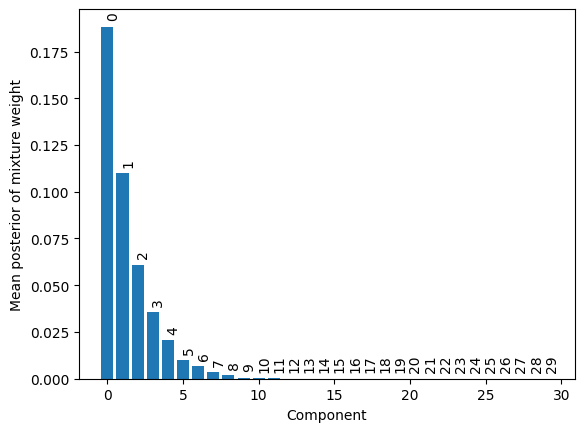

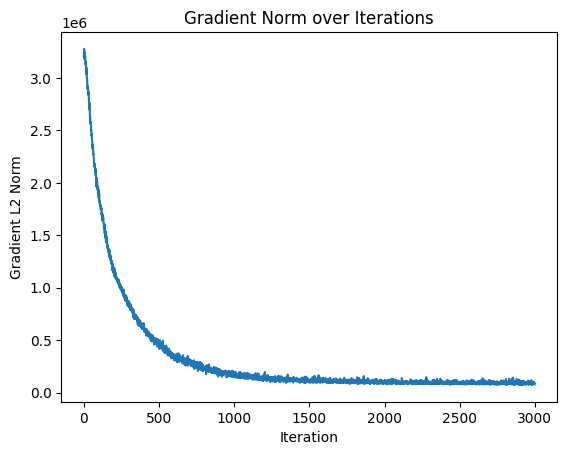

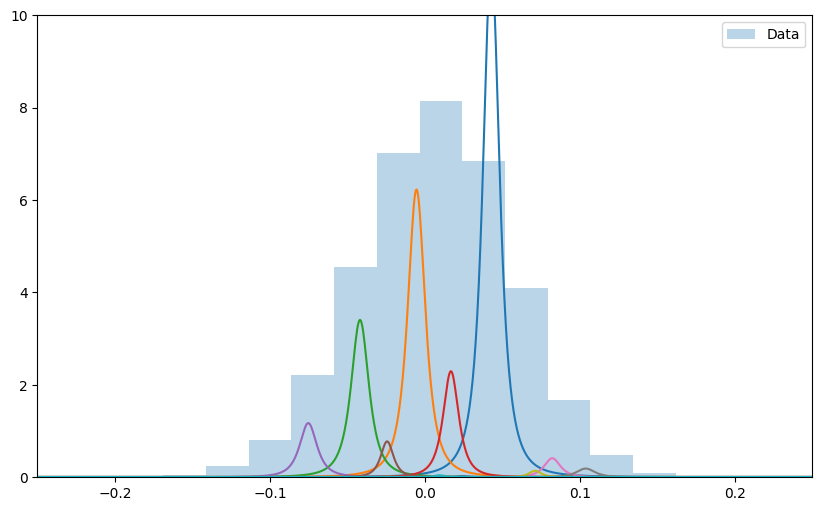

,beta,scale,nu,mu,weights
0,0.429487,0.005920,1.905676,0.042845,1.882647e-01
1,0.439320,0.006206,1.926201,-0.005387,1.098664e-01
2,0.435392,0.006299,1.910875,-0.041830,6.104901e-02
3,0.449657,0.005477,1.990334,0.016820,3.559813e-02
4,0.471988,0.006151,1.876850,-0.075205,2.056414e-02
5,0.427021,0.004467,2.000630,-0.024343,9.823621e-03
6,0.506147,0.005711,1.985222,0.082212,6.671733e-03
7,0.538218,0.006524,1.955357,0.103793,3.503625e-03
8,0.582408,0.004387,2.035493,0.071132,1.750747e-03
9,0.426358,0.004317,1.991082,0.009347,5.352068e-04


In [171]:
def inverse_softplus(y):
    return jnp.log(np.exp(y) - 1)

def inverse_sigmoid(y):
    return jnp.log(y / (1 - y))

def mu(n, s, phi, c, cs):
    return jnp.log2((2 * n + (1 - n) * (s * c + (1 - s) * cs)) / \
                        (2 * n + (1 - n) * phi))

def stick_breaking(beta, epsilon=1e-10):
    portion_remaining = jnp.concatenate([jnp.array([1]), jnp.cumprod(1 - beta[:-1])])
    portion_remaining += epsilon
    portion_remaining /= jnp.sum(portion_remaining)
    return beta * portion_remaining

def logprior_fn(params):
    alpha_param, beta_param, mu_param, nu_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    alpha = jax.nn.softplus(alpha_param)
    beta = jax.nn.sigmoid(beta_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    mu = mu_param
    
    log_prior =  \
            Gamma(1, 1).log_prob(alpha) + \
            jnp.sum(Beta(2, alpha).log_prob(beta), axis=-1) + \
            jnp.sum(HalfNormal(1).log_prob(scale), axis=-1) + \
            jnp.sum(Gamma(1, .1).log_prob(nu), axis=-1) + \
            jnp.sum(Normal(0, 1).log_prob(mu), axis=-1)
            
    return log_prior

def loglikelihood_fn(params, data):
    alpha_param, beta_param, mu_param, nu_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    beta = jax.nn.sigmoid(beta_param)
    weights = stick_breaking(beta)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    mu = mu_param
    
    component_dists = StudentT(nu, mu, scale)
    likelihood_dist = MixtureSameFamily(Categorical(weights), component_dists)
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))
    
    return log_likelihood

def logposterior_fn(params, data):
    return logprior_fn(params) + jnp.mean(len(data) * jax.jit(jax.vmap(loglikelihood_fn, in_axes=(None, 0)))(params, data))
grad_log_post = jax.jit(jax.value_and_grad(logposterior_fn))


key = jax.random.PRNGKey(np.random.randint(0, 1000))

max_cluster_num = 30

data_size = observations.shape[0]
batch_size = data_size

alpha = inverse_softplus(1)
beta = inverse_sigmoid(jnp.ones(max_cluster_num) * 0.5)

def create_centered_array(length, center_value=0.005, spread=0.5):
    x = jnp.linspace(-1, 1, length)
    y = jnp.exp(-x**2 / (2 * spread**2))
    y = y * center_value / jnp.max(y)
    return y
scale_vals = create_centered_array(max_cluster_num, center_value=0.025, spread=1)
scale = inverse_softplus(scale_vals)
scale = inverse_softplus(jnp.ones(max_cluster_num) * 0.005)
nu_vals = create_centered_array(max_cluster_num, center_value=1, spread=0.5)
nu = inverse_softplus(jnp.ones(max_cluster_num) * 2)
mu = Uniform(-.05, .05).sample(key, (max_cluster_num,))

init_params = {'alpha': alpha, 'beta': beta, 'mu': mu, 'nu': nu, 'scale': scale}

Niters = 3_000
batch_size_adam = data_size
dt_adam = 1e-4
opt = optax.amsgrad(learning_rate=dt_adam)
# scheduler = optax.cosine_decay_schedule(init_value=dt_adam, decay_steps=Niters)
# opt = optax.chain(optax.scale_by_adam(b1=0.9, b2=0.999), optax.scale_by_schedule(scheduler))
# opt = optax.chain(optax.clip_by_global_norm(max_grad_norm), optax.adam(learning_rate))


@scan_tqdm(Niters, print_rate=1)
@jax.jit
def body(carry, i):
    key, state, params = carry
    key, subkey = jax.random.split(key)
    idx_batch = jax.random.choice(key=subkey, a=jnp.arange(data_size), shape=(batch_size,))
    minibatch_data = tuple([elem[idx_batch] for elem in (observations,)])
    lp_val, param_grad = grad_log_post(params, *minibatch_data)
    
    grad_norm = jax.tree_util.tree_reduce(jnp.add, jax.tree_map(lambda x: jnp.sum(x**2), param_grad))
    grad_norm = jnp.sqrt(grad_norm)
    
    neg_param_grad = jax.tree_util.tree_map(lambda x: -x, param_grad)
    updates, state = opt.update(neg_param_grad, state)
    params = optax.apply_updates(params, updates)
    return (key, state, params), (lp_val, grad_norm)

def run_optimizer(key, Niters, params):
    state = opt.init(params)
    (key, state, params), (logpost_array, grad_norms) = jax.lax.scan(
        body, (key, state, params), jnp.arange(Niters)
    )
    return params, logpost_array, grad_norms

opt_params, log_post_list, gradient_norms = run_optimizer(key, Niters, init_params)

alpha_posterior_mean = jax.nn.softplus(opt_params['alpha'])
beta_posterior_mean = jax.nn.sigmoid(opt_params['beta'])
scale_posterior_mean = jax.nn.softplus(opt_params['scale'])
nu_posterior_mean = jax.nn.softplus(opt_params['nu'])
mu_posterior_mean = opt_params['mu']
weights_posterior_mean = stick_breaking(jax.nn.sigmoid(opt_params['beta']))

states = pd.DataFrame({
    'beta': beta_posterior_mean,
    'scale': scale_posterior_mean,
    'nu': nu_posterior_mean,
    'mu': mu_posterior_mean,
    'weights': weights_posterior_mean
})

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), states['weights'])
for bar, state in zip(bars, range(0, max_cluster_num)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()

plt.plot(gradient_norms)
plt.xlabel('Iteration')
plt.ylabel('Gradient L2 Norm')
plt.title('Gradient Norm over Iterations')
# plt.ylim(0, 20)
plt.show()


plt.figure(figsize=(10, 6))
x = np.linspace(-.25, .25, 1000)
for df, loc, scale, weight in zip(nu_posterior_mean, mu_posterior_mean, scale_posterior_mean, weights_posterior_mean):
    y = t.pdf(x, df, loc, scale)
    plt.plot(x, y * weight)
plt.hist(observations, bins=100, density=True, label='Data', alpha=0.3)
plt.legend()
plt.xlim(-.25, .25)
plt.ylim(0, 10)
plt.show()

states.sort_values('weights', ascending=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

n:  0.8123634
s:  0.5
phi:  3.4323359


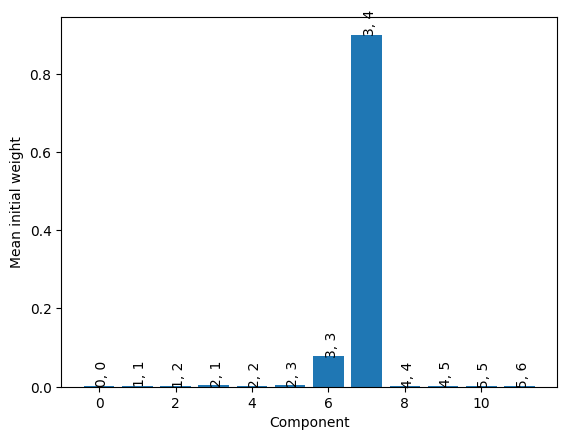

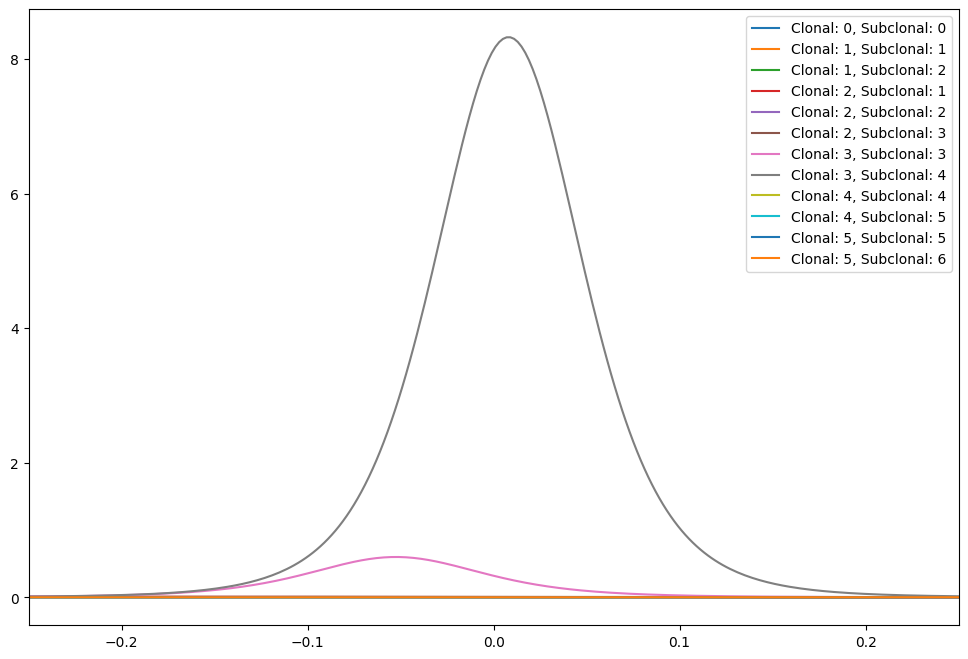

,clonal,subclonal,weights,mu,scale,nu
0,0,0,0.003051,-0.48170608,0.530434,2.234693
1,1,1,0.002029,-0.32403103,0.278480,1.992571
2,1,2,0.001914,-0.2512176,0.265853,1.991674
3,2,1,0.004404,-0.2512176,0.180050,2.529103
4,2,2,0.001399,-0.18190323,0.433372,1.958650
5,2,3,0.003993,-0.115767054,0.192979,2.485656
6,3,3,0.078375,-0.052530084,0.049116,4.070885
7,3,4,0.899626,0.008051047,0.041101,5.235020
8,4,4,0.001231,0.06619022,0.253663,2.209181
9,4,5,0.002075,0.12207708,0.175969,2.452710


In [54]:
def mu(n, s, phi, c, cs):
    return jnp.log2((2 * n + (1 - n) * (s * c + (1 - s) * cs)) / \
                        (2 * n + (1 - n) * phi))

def inverse_sigmoid(y):
    return jnp.log(y / (1 - y))

def inverse_softplus(y):
    return jnp.log(np.exp(y) - 1)

def stick_breaking(beta):
    portion_remaining = jnp.concatenate([jnp.array([1]), jnp.cumprod(1 - beta[:-1])])
    return beta * portion_remaining

def dirichlet_prior(states, target_state=jnp.array([2,2]), alpha=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*alpha**2))

def euclidean_distance(point1, point2):
    return jnp.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def prior_weights(points, target=jnp.array([2, 2]), sigma=2.5, gamma=1, subclone_w=5):
    distances = jnp.sqrt(jnp.sum((jnp.abs(points - target)), axis=1))
    weights = jnp.exp(-distances**2 / sigma) * (jnp.sum(points, axis=1) + 1)**gamma
    mask = points[:, 0] != points[:, 1]
    weights = jnp.where(mask, weights / subclone_w, weights)
    mask = (points[:, 0] != points[:, 1]) & (points[:, 0] > points[:, 1])
    weights = jnp.where(mask, weights * 0.5, weights)
    total_weight = jnp.sum(weights)
    weights = weights / total_weight
    return weights

def prior_scales(points, target=jnp.array([2, 2]), sigma=2.5, gamma=1, subclone_scale=5):
    distances = jnp.sqrt(jnp.sum((jnp.abs(points - target)), axis=1))
    scales = jnp.exp(-distances**2 / sigma) * (jnp.sum(points, axis=1) + 1)**gamma
    mask = points[:, 0] != points[:, 1]
    scales = jnp.where(mask, scales / subclone_scale, scales)
    mask = (points[:, 0] != points[:, 1]) & (points[:, 0] > points[:, 1])
    scales = jnp.where(mask, scales * 0.5, scales)
    total_scale = jnp.sum(scales)
    scales = scales / total_scale
    return scales

def logprior_fn(params):
    n_param, nu_param, s_param, scale_param, weights_param = jax.tree_util.tree_flatten(params)[0]
    weights = jax.nn.softmax(weights_param, axis=-1)
    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    
    penalty = 1
    regularization_term = -penalty * jnp.mean(jnp.square(weights - prior_weights(states)))
    
    log_prior =  \
            Dirichlet(prior_weights(states)).log_prob(weights) + \
            Beta(2, 2).log_prob(n) + \
            Beta(2, 2).log_prob(s) + \
            jnp.sum(InverseGamma(1, 1).log_prob(scale), axis=-1) + \
            jnp.sum(InverseGamma(1, 1).log_prob(nu), axis=-1) + \
            regularization_term
            
    return log_prior / data_size


def loglikelihood_fn(params, data):
    n_param, nu_param, s_param, scale_param, weights_param = jax.tree_util.tree_flatten(params)[0]
    weights = jax.nn.softmax(weights_param, axis=-1)
    n = jax.nn.sigmoid(n_param)
    s_ = jax.nn.sigmoid(s_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    
    equal_states = jnp.all(states[:, 0] == states[:, 1])
    s_ = jnp.where(equal_states, 0, s)
    phi = (1-s_) * jnp.sum(weights * states[:, 0]) + s_ * jnp.sum(weights * states[:, 1])
    mu = jnp.log2((2 * n + (1 - n) * ((1 - s_) * states[:, 0] + s_ * states[:, 1])) / \
                        (2 * n + (1 - n) * phi))
    
    likelihood_dist = MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale))
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))
    return log_likelihood / data_size


def logdensity_fn(params, data=observations):
    frac = data_size // 100
    data = jax.random.permutation(key, data, independent=True)[:frac]
    return logprior_fn(params) + loglikelihood_fn(params, data)

clonal = 6
states_set = [[0,0], 
            [1,1], [1,2], 
            [2,1], [2,2], [2,3], 
            [3,3], [3,4],
            [4,4], [4,5],
            [5,5], [5,6]]
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
max_cluster_num = len(states)

data_size = observations.shape[0]
batch_size = data_size // 100

weights = prior_weights(states)
n = inverse_sigmoid(0.5)
s = inverse_sigmoid(0.5)
scale = prior_scales(states)
nu = jnp.ones(max_cluster_num) * 1
init_params = {"weights": weights, "scale": scale, "nu": nu, "s": s, "n": n}

key = jax.random.PRNGKey(np.random.randint(0, 1000))

batch_size_adam = data_size
dt_adam = 5e-3
opt = optax.adam(learning_rate=dt_adam, b1=0.9, b2=0.999)
optimizer = build_optax_optimizer(opt, loglikelihood_fn, logprior_fn, (observations,), batch_size_adam)
Niters = 1_000
opt_params, log_post_list = optimizer(key, Niters, init_params)
n_post = jax.nn.sigmoid(opt_params['n'])
s_post = jax.nn.sigmoid(opt_params['s'])
weights_post = jax.nn.softmax(opt_params['weights'], axis=-1)
scale_post = jax.nn.softplus(opt_params['scale'])
nu_post = jax.nn.softplus(opt_params['nu'])
phi = (1-s_post) * jnp.sum(weights_post * states[:, 0]) + s_post * jnp.sum(weights_post * states[:, 1])
print('n: ', n_post)
print('s: ', s_post)
print('phi: ', phi)
states_df['weights'] = weights_post
states_df['mu'] = states_df[['clonal', 'subclonal']].apply(lambda x: mu(n_post, s_post, float(phi), x[0], x[1]), axis=1)
states_df['scale'] = scale_post
states_df['nu'] = nu_post

plt.ylabel('Mean initial weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), weights_post)
for bar, state in zip(bars, states):
    state = f'{int(state[0])}, {int(state[1])}'
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
x = np.linspace(-1, 1, 1000)
for index, row in states_df.iterrows():
    df, loc, scale = row['nu'], row['mu'], row['scale']
    weight = row['weights']
    y = t.pdf(x, df, loc, scale)
    plt.plot(x, y * weight, label=f'Clonal: {int(row["clonal"])}, Subclonal: {int(row["subclonal"])}')
plt.xlim(-.25, .25)
plt.legend()
plt.show()

states_df
# dt = 1e-7
# L = 30
# num_chains = 4

# num_samples = 10_000
# sample_size = 1_000
# burn_in = 5_000
# thinning = 10

# init_fn, kernel, get_params = build_sghmc_kernel(dt, L, loglikelihood_fn, logprior_fn, (observations,), batch_size, alpha=1)
# kernel = jax.jit(kernel)

# weights_posterior, n_posterior, s_posterior, scale_posterior, nu_posterior = [], [], [], [], []

# key, subkey = jax.random.split(key)
# state = init_fn(subkey, opt_params)

# pbar = tqdm(total=num_samples, desc='Running sampler')
# n_cur, s_cur = [], []
# for i in range(num_samples):
#     key, subkey = jax.random.split(key)
#     state = kernel(i, subkey, state)
#     n_cur.append(jax.nn.sigmoid(get_params(state)['n']))
#     s_cur.append(jax.nn.sigmoid(get_params(state)['s']))
#     if i > burn_in and i % thinning == 0:
#         weights_posterior.append(get_params(state)['weights'])
#         n_posterior.append(get_params(state)['n'])
#         s_posterior.append(get_params(state)['s'])
#         scale_posterior.append(get_params(state)['scale'])
#         nu_posterior.append(get_params(state)['nu'])
#     if i % 100 == 0:
#         n = f'{jnp.array(n_cur).mean():.4f}'
#         s = f'{jnp.array(s_cur).mean():.4f}'
#         pbar.set_postfix({'n': n, 's': s})
#         n_cur, s_cur = [], []
#     pbar.update(1)

# weights_posterior = jax.nn.softmax(jnp.array(weights_posterior), axis=-1)
# n_posterior = jax.nn.sigmoid(jnp.array(n_posterior))
# s_posterior = jax.nn.sigmoid(jnp.array(s_posterior))
# scale_posterior = jax.nn.softplus(jnp.array(scale_posterior))
# nu_posterior = jax.nn.softplus(jnp.array(nu_posterior))

# weights_posterior_mean = jnp.mean(weights_posterior, axis=0)
# n_posterior_mean = jnp.mean(n_posterior)
# s_posterior_mean = jnp.mean(s_posterior)
# scale_posterior_mean = jnp.mean(scale_posterior, axis=0)
# nu_posterior_mean = jnp.mean(nu_posterior, axis=0)

# print(f'n: {n_posterior_mean:.4f}')
# print(f's: {s_posterior_mean:.4f}')
# phi = (1-s_posterior_mean) * jnp.sum(weights_posterior_mean * states[:, 0]) + s_posterior_mean * jnp.sum(weights_posterior_mean * states[:, 1])
# print(f'phi: {phi:.4f}')

# plt.ylabel('Mean posterior of mixture weight')
# plt.xlabel('Component')
# bars = plt.bar(range(0, max_cluster_num), weights_posterior_mean)
# for bar, state in zip(bars, states):
#     state = f'{int(state[0])}, {int(state[1])}'
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
# plt.show()

# states_df['weights'] = weights_posterior_mean
# states_df['mu'] = states_df[['clonal', 'subclonal']].apply(lambda x: mu(n_posterior_mean, s_posterior_mean, float(phi), x[0], x[1]), axis=1)
# states_df['scale'] = scale_posterior_mean
# states_df['nu'] = nu_posterior_mean
# states_df


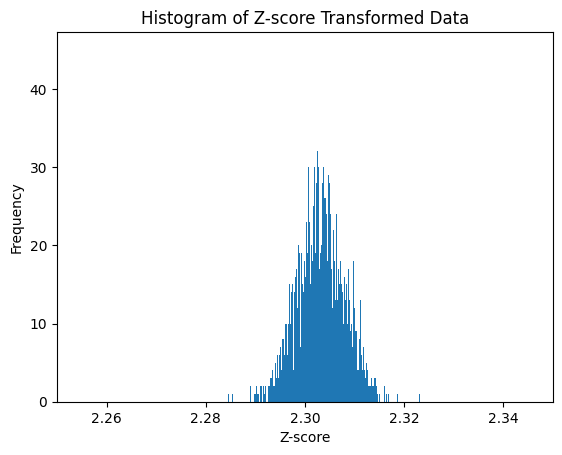

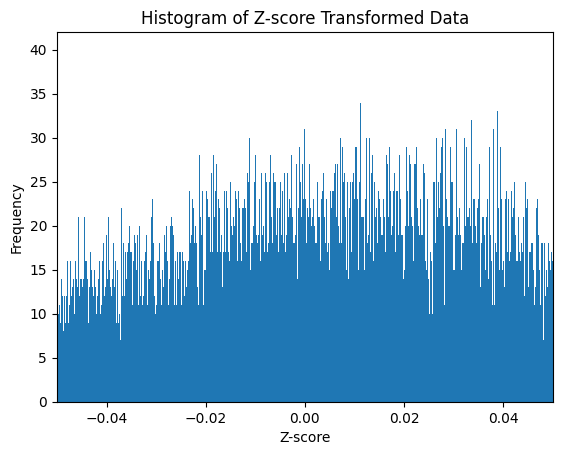

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data or use your existing data
np.random.seed(0)
data = observations

# Compute the mean and standard deviation of the data
mean = np.mean(data)
std = np.std(data)

# Apply the Z-score transformation
transformed_data = np.log(data + 10)

# Plot the histogram of the transformed data
plt.hist(transformed_data, bins=len(np.unique(data)))
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Histogram of Z-score Transformed Data')
plt.xlim(2.25, 2.35)
plt.show()

# Plot the histogram of the transformed data
plt.hist(data, bins=len(np.unique(data)))
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Histogram of Z-score Transformed Data')
plt.xlim(-.05, .05)
plt.show()

In [ ]:
def inference_loop(rng_key, sgmcmc_kernel, initial_state, num_samples): 
    @jax.jit
    @scan_tqdm(num_samples, print_rate=1)
    def one_step(state, x):
        key, sub_key = jax.random.split(rng_key)
        state = sgmcmc_kernel(x, sub_key, state)
        return state, state
    _, states = jax.lax.scan(one_step, initial_state, jnp.arange(num_samples))
    return states

samples_ = inference_loop(key, kernel, init_state, num_samples)
samples = get_params(samples_)
# # batch_size_adam = data_size
# # dt_adam = 1e-4
# # opt = optax.adam(learning_rate=dt_adam)
# # optimizer = build_optax_optimizer(opt, loglikelihood_fn, logprior_fn, (observations,), batch_size_adam)
# # Niters = 10_000
# # opt_params, log_post_list = optimizer(key, Niters, init_params)
# # print('alpha: ', jax.nn.softplus(opt_params['alpha']).mean())
# # print('n: ', jax.nn.sigmoid(opt_params['n']).mean())
# # print('s: ', jax.nn.sigmoid(opt_params['s']).mean())
# # print('phi: ', jax.nn.softplus(opt_params['phi']).mean())

# # sampler = build_sgldCV_sampler(dt, loglikelihood_fn, logprior_fn, (observations,), batch_size, opt_params, pbar=True)
# sampler = build_sgld_SVRG_sampler(dt, loglikelihood_fn, logprior_fn, (observations,), batch_size, pbar=True, update_rate=1)
# # sampler = build_sghmcCV_sampler(1e-6, L, loglikelihood_fn, logprior_fn, (observations,), batch_size, opt_params, pbar=True)
# # sampler = build_psgld_sampler(1e-8, loglikelihood_fn, logprior_fn, (observations,), batch_size, pbar=True)
# # sampler = build_sghmc_SVRG_sampler(1e-6, L, loglikelihood_fn, logprior_fn, (observations,), batch_size, pbar=True, update_rate=1000)
# # sampler = build_sgnht_sampler(1e-7, loglikelihood_fn, logprior_fn, (observations,), batch_size, pbar=True)
# # sampler = build_sgld_sampler(dt, loglikelihood_fn, logprior_fn, (observations,), batch_size, pbar=True)
# sampler = partial(jax.jit, static_argnums=(1,))(sampler)

# Nsamples = 10_000
# samples = sampler(key, Nsamples, init_params)

# sample_size = 1_000
# print('alpha: ', jax.nn.softplus(samples['alpha'][-sample_size:]).mean())
# print('n: ', jax.nn.sigmoid(samples['n'][-sample_size:]).mean())
# print('s: ', jax.nn.sigmoid(samples['s'][-sample_size:]).mean())
# print('phi: ', jax.nn.softplus(samples['phi'][-sample_size:]).mean())

# alpha_posterior = jax.nn.softplus(samples['alpha'][-sample_size:])
# weights_posterior = jax.nn.softmax(samples['weights'][-sample_size:])
# n_posterior = jax.nn.sigmoid(samples['n'][-sample_size:])
# s_posterior = jax.nn.sigmoid(samples['s'][-sample_size:])
# phi_posterior = jax.nn.softplus(samples['phi'][-sample_size:])
# scale_posterior = jax.nn.softplus(samples['scale'][-sample_size:])
# nu_posterior = jax.nn.softplus(samples['nu'][-sample_size:])

# alpha_mean = alpha_posterior.mean()
# weights_mean = weights_posterior.mean(axis=0)
# n_mean = n_posterior.mean()
# s_mean = s_posterior.mean()
# phi_mean = phi_posterior.mean()
# scale_mean = scale_posterior.mean(axis=0)
# nu_mean = nu_posterior.mean(axis=0)

# plt.ylabel('Mean posterior of mixture weight')
# plt.xlabel('Component')
# bars = plt.bar(range(0, max_cluster_num), weights_mean)
# for bar, state in zip(bars, states):
#     state = f'{int(state[0])}, {int(state[1])}'
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
# plt.show()


# plt.ylabel('Sample value of alpha')
# plt.xlabel('Iteration')
# plt.plot(jax.nn.softplus(samples['alpha']))
# plt.show()